Kron time:  0.5096509456634521
Solve time:  35.665860176086426
Total time:  36.17551112174988
Error inf:  8.208163806422419e-07
Error sq:  4.1040919736634046e-07


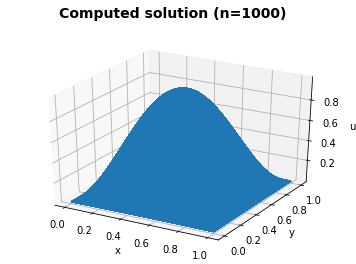

In [52]:
#Import necessary modules
import numpy as np
from scipy.sparse import diags, csr_matrix, kron
from scipy.sparse.linalg import spsolve
from scipy.linalg import schur, solve_sylvester
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

class SolvePDE:
    
    def __init__(self, n):
        #Define parameters
        self.n = n
        self.N = self.n+2
        self.h = 1/(self.n+1)
        
        #Define internal nodes in each direction
        self.x = np.linspace(self.h, 1-self.h, self.n)
        self.y = np.linspace(self.h, 1-self.h, self.n)
        
        #Create internal mesh (excludes boundaries)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')
        
        #Define T, F and U_exact
        diagonals = [[-2],[1],[1]]
        self.T = np.multiply(-1/self.h**2, diags(diagonals, [0, -1, 1], shape=(self.n, self.n)).toarray())
        self.F = 2 * np.pi**2 * np.sin(np.pi*self.X) * np.sin(np.pi*self.Y)
        self.U_exact = np.sin(np.pi*self.X) * np.sin(np.pi*self.Y)

    def linearSolve(self):
        #Reshape F and U_exact into vectors
        self.F = np.reshape(self.F, -1)
        self.U_exact = np.reshape(self.U_exact, -1)
        
        start_time = time.time()
        
        #Define A = I kron T + T^t kron I and convert to sparse format
        self.A = kron(np.eye(self.n),self.T) + kron(self.T.transpose(),np.eye(self.n))
        self.A = csr_matrix(self.A)
        
        kron_time = time.time()
        
        #Solve linear system AU=F using sparse solver
        self.U = spsolve(self.A, self.F)
        
        solve_time = time.time()
        
        #Print timings
        print('Kron time: ', kron_time - start_time)
        print('Solve time: ', solve_time - kron_time)
        print('Total time: ', solve_time - start_time)
        
        #Measure and output error, and plot solution
        self.measureError()
        self.plotSolution()
        
    def spSylSolve(self):
        #Solve system and measure time
        start_time = time.time()
        self.U = solve_sylvester(self.T, self.T, self.F)
        end_time = time.time()
        
        #Print timings
        print('Total time: ', end_time - start_time)
        
        #Reshape solution - for measuring error and plotting
        self.U = np.reshape(self.U, -1)
        
        #Measure and output error, and plot solution
        self.measureError()
        self.plotSolution()
        
    def measureError(self):
        #Compute error at each node
        self.error_inf = 0
        self.error_sq = 0
        for i in range(0,self.n**2):
            self.error_sq += np.absolute(self.U_exact[i] - self.U[i])**2
            if np.absolute(self.U_exact[i] - self.U[i]) > self.error_inf:
                self.error_inf = np.absolute(self.U_exact[i] - self.U[i])

        self.error_sq = (self.error_sq * self.h**2)**0.5
        
        #Output error
        print('Error inf: ', self.error_inf)
        print('Error sq: ', self.error_sq)
        
    def plotSolution(self):
        plt.figure(0)
        plt.suptitle('Computed solution (n=' + str(self.n) +')', fontsize=14, fontweight='bold')
        self.ax = plt.axes(projection='3d')
        self.xline = np.reshape(self.X, -1)
        self.yline = np.reshape(self.Y, -1)
        self.zline = self.U
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('u')
        self.ax.plot3D(self.xline, self.yline, self.zline)
        
    def plotActualSolution(self):
        plt.figure(1)
        plt.suptitle('Exact solution (n=' + str(n) +')', fontsize=14, fontweight='bold')
        self.ax = plt.axes(projection='3d')
        self.xline = np.reshape(self.X, -1)
        self.yline = np.reshape(self.Y, -1)
        self.zlineActual = np.reshape(self.U_exact, -1)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('u')
        self.ax.plot3D(self.xline, self.yline, self.zlineActual)


        
p = SolvePDE(1000)
p.linearSolve()
#p.spSylSolve()